In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display, HTML
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_percentage_error

# if torch.backends.mps.is_available():
#   torch.set_default_device("mps")
use_saved_model = False

figures_dir = "figures"
data_dir = "data"
sns.set_theme(style="darkgrid")

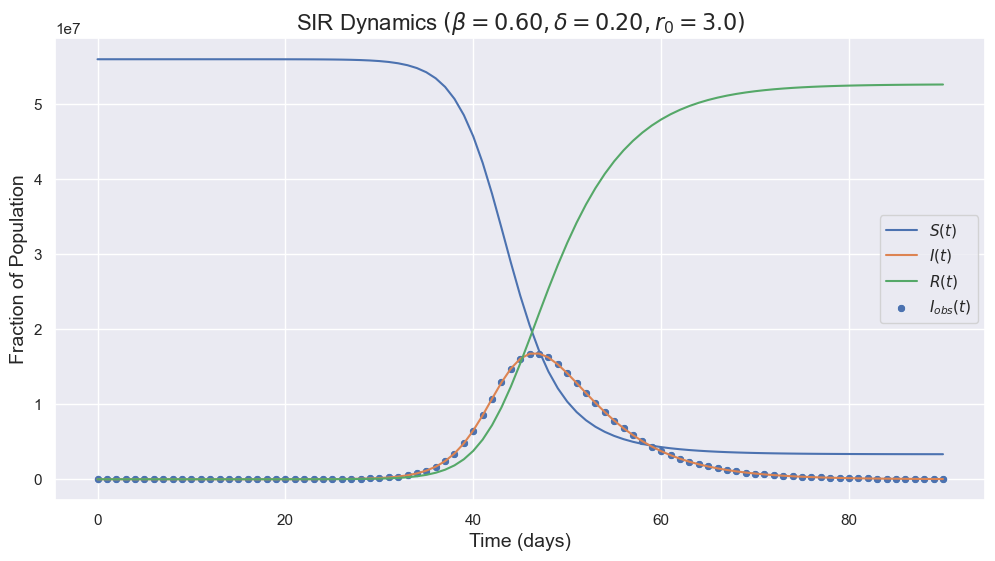

In [25]:
# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day)
r0 = 3.0  # Basic reproduction number
beta_true = delta * r0  # Infection rate (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i / N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [S0, I0, R0], t, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)

plt.subplots(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label=r"$S(t)$")
sns.lineplot(x=t, y=i_true, label=r"$I(t)$")
sns.lineplot(x=t, y=r_true, label=r"$R(t)$")
sns.scatterplot(x=t, y=i_obs, label=r"$I_{obs}(t)$")

plt.title(
  f"SIR Dynamics $\\left(\\beta={beta_true:.2f}, \\delta={delta:.2f}, r_0={r0}\\right)$",
  fontsize=16
)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Fraction of Population", fontsize=14)

plt.savefig(f"{figures_dir}/synthetic_data.png", dpi=300)

In [26]:
s_true = s_true / N
i_true = i_true / N
r_true = r_true / N

ic = np.array([S0, I0, R0]) / N
i_obs = i_obs / N

# Convert observation data to torch tensors for training
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32)
ic_tensor = torch.tensor(ic, dtype=torch.float32).reshape(1, -1)

t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
i_obs_tensor = torch.tensor(i_obs, dtype=torch.float32).reshape(-1, 1)

In [27]:
class Square(nn.Module):
  """
  A module that squares its input element-wise.
  Useful as a final activation to enforce non-negativity.
  """

  @staticmethod
  def forward(x):
    return torch.square(x)


def create_fnn(layers, activation, output_activation):
  layers_modules = []
  for i in range(len(layers) - 1):
    layers_modules.append(nn.Linear(layers[i], layers[i + 1]))
    if i < len(layers) - 2:
      layers_modules.append(activation)
  layers_modules.append(output_activation)

  net = nn.Sequential(*layers_modules)

  # Initialize weights and biases (Xavier initialization for weights, zeros for biases)
  for m in net:
    if isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)

  return net


class PINN(nn.Module):
  def __init__(
      self,
      given_N,
      given_delta,
      initial_beta,
      layers=None,
      activation=nn.Tanh(),
      output_activation=Square(),
  ):
    if layers is None:
      layers = [1] + [50] * 3 + [1]

    super(PINN, self).__init__()
    self.net_S = create_fnn(layers, activation, output_activation)
    self.net_I = create_fnn(layers, activation, output_activation)

    self.beta = torch.nn.Parameter(
      torch.tensor(initial_beta, dtype=torch.float32)
    )
    self.delta = given_delta
    self.N = torch.tensor(given_N, dtype=torch.float32)

  def forward(self, x):
    S = self.net_S(x)
    I = self.net_I(x)
    R = self.N.to(x.device) - S - I

    return torch.cat([S, I, R], dim=1)

  def compute_pde_residuals(self, x):
    """Compute residuals of SIR ODE at times t.
    Returns tensors of the same shape as t."""
    x.requires_grad_(True)
    S = self.net_S(x)
    I = self.net_I(x)

    dS_dt = torch.autograd.grad(
      S, x, grad_outputs=torch.ones_like(S), create_graph=True
    )[0]
    dI_dt = torch.autograd.grad(
      I, x, grad_outputs=torch.ones_like(I), create_graph=True
    )[0]

    res_S = dS_dt + self.beta * S * I
    res_I = dI_dt - self.beta * S * I + self.delta * I
    return res_S, res_I

In [28]:
# Hyperparameters
sampling_points = 1000
iterations = 60000
weights_updates = 100
log_interval = 1000
learning_rate = 1e-3

model = PINN(given_N=1.0, given_delta=delta, initial_beta=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

loss_df = pd.DataFrame(
  columns=[
    "weight_pde", "L_pde",
    "weight_ic", "L_ic",
    "weight_data", "L_data",
    "total_loss"
  ]
)
evolution_df = pd.DataFrame(columns=["beta"])

In [29]:
def loss_pde(x):
  res_S, res_I = model.compute_pde_residuals(x)
  loss_res_S = loss_fn(res_S, torch.zeros_like(res_S))
  loss_res_I = loss_fn(res_I, torch.zeros_like(res_I))
  return loss_res_S + loss_res_I


def loss_ic():
  ic_pred = model(t0_tensor)
  return loss_fn(ic_pred, ic_tensor)


def loss_data():
  I = model(t_tensor)[:, 1].reshape(-1, 1)
  return loss_fn(I, i_obs_tensor)

In [30]:
L_pde_history = []
L_ic_history = []
L_data_history = []
loss_history = []
weight_ode_history = []
weight_ic_history = []
weight_data_history = []
beta_evolution = []


def train():
  weight_pde = torch.tensor(1.0)
  weight_ic = torch.tensor(1.0)
  weight_data = torch.tensor(1.0)
  eps = 1e-5  # small constant for numerical stability

  for it in range(1, iterations + 1):
    optimizer.zero_grad()

    t_sample = torch.rand(sampling_points, 1) * t_end

    L_pde = loss_pde(t_sample)
    L_ic = loss_ic()
    L_data = loss_data()

    if it % weights_updates == 0:
      grads_pde = torch.autograd.grad(
        L_pde, model.parameters(), retain_graph=True, create_graph=False
      )
      ic_params = list(model.net_S.parameters()) + list(
        model.net_I.parameters()
      )
      grads_ic = torch.autograd.grad(
        L_ic, ic_params, retain_graph=True, create_graph=False
      )
      data_params = ic_params
      grads_data = torch.autograd.grad(
        L_data, data_params, retain_graph=True, create_graph=False
      )

      grad_norm_pde = torch.cat([g.flatten() for g in grads_pde]).norm()
      grad_norm_ic = torch.cat([g.flatten() for g in grads_ic]).norm()
      grad_norm_data = torch.cat([g.flatten() for g in grads_data]).norm()

      weight_pde = 1 / (grad_norm_pde + eps)
      weight_ic = 1 / (grad_norm_ic + eps)
      weight_data = 1 / (grad_norm_data + eps)

      # normalize weights
      weight_sum = weight_pde + weight_ic + weight_data
      weight_pde /= weight_sum
      weight_ic /= weight_sum
      weight_data /= weight_sum

    loss = (
        weight_pde * L_pde +
        weight_ic * L_ic +
        weight_data * L_data
    )

    loss.backward()
    optimizer.step()

    L_pde_history.append(L_pde.item())
    L_ic_history.append(L_ic.item())
    L_data_history.append(L_data.item())
    loss_history.append(loss.item())
    weight_ode_history.append(weight_pde.item())
    weight_ic_history.append(weight_ic.item())
    weight_data_history.append(weight_data.item())
    beta_evolution.append(model.beta.item())

    if it % log_interval == 0:
      print(
        f"[{it:<{len(str(iterations))}}/{iterations}]: "
        f"β = {model.beta.item():.4f} "
        f"| Loss = {loss.item():.2e}"
      )

  save_training()


def save_training():
  loss_df['weight_pde'] = weight_ode_history
  loss_df['L_pde'] = L_pde_history
  loss_df['weight_ic'] = weight_ic_history
  loss_df['L_ic'] = L_ic_history
  loss_df['weight_data'] = weight_data_history
  loss_df['L_data'] = L_data_history
  loss_df['total_loss'] = loss_history

  evolution_df['beta'] = beta_evolution

  loss_df.to_csv(f"{data_dir}/loss_history.csv", float_format='%.6e')
  evolution_df.to_csv(f"{data_dir}/beta_history.csv", float_format='%.6e')

  torch.save(model.state_dict(), f"{data_dir}/model.pth")

In [31]:
if use_saved_model:
  try:
    state_dict = torch.load(f"{data_dir}/model.pth", weights_only=True)
    model.load_state_dict(state_dict)
    loss_df = pd.read_csv(f"{data_dir}/loss_history.csv")
    evolution_df = pd.read_csv(f"{data_dir}/beta_history.csv")
  except FileNotFoundError:
    train()
else:
  train()

[1000 /60000]: β = 0.2890 | Loss = 1.62e-05
[2000 /60000]: β = 0.2892 | Loss = 3.07e-06
[3000 /60000]: β = 0.2894 | Loss = 1.72e-06
[4000 /60000]: β = 0.2897 | Loss = 1.85e-06
[5000 /60000]: β = 0.2933 | Loss = 1.32e-05
[6000 /60000]: β = 0.2979 | Loss = 4.52e-04
[7000 /60000]: β = 0.3202 | Loss = 3.61e-07
[8000 /60000]: β = 0.3205 | Loss = 6.16e-06
[9000 /60000]: β = 0.3198 | Loss = 2.61e-06
[10000/60000]: β = 0.3163 | Loss = 5.51e-07
[11000/60000]: β = 0.2795 | Loss = 1.46e-07
[12000/60000]: β = 0.3001 | Loss = 5.49e-07
[13000/60000]: β = 0.2412 | Loss = 4.50e-06
[14000/60000]: β = 0.2412 | Loss = 1.76e-06
[15000/60000]: β = 0.2412 | Loss = 2.03e-06
[16000/60000]: β = 0.2412 | Loss = 1.07e-05
[17000/60000]: β = 0.2415 | Loss = 8.52e-07
[18000/60000]: β = 0.2415 | Loss = 1.35e-06
[19000/60000]: β = 0.2436 | Loss = 6.04e-07
[20000/60000]: β = 0.2457 | Loss = 3.62e-07
[21000/60000]: β = 0.2512 | Loss = 6.42e-05
[22000/60000]: β = 0.2553 | Loss = 9.09e-06
[23000/60000]: β = 0.2613 | Loss

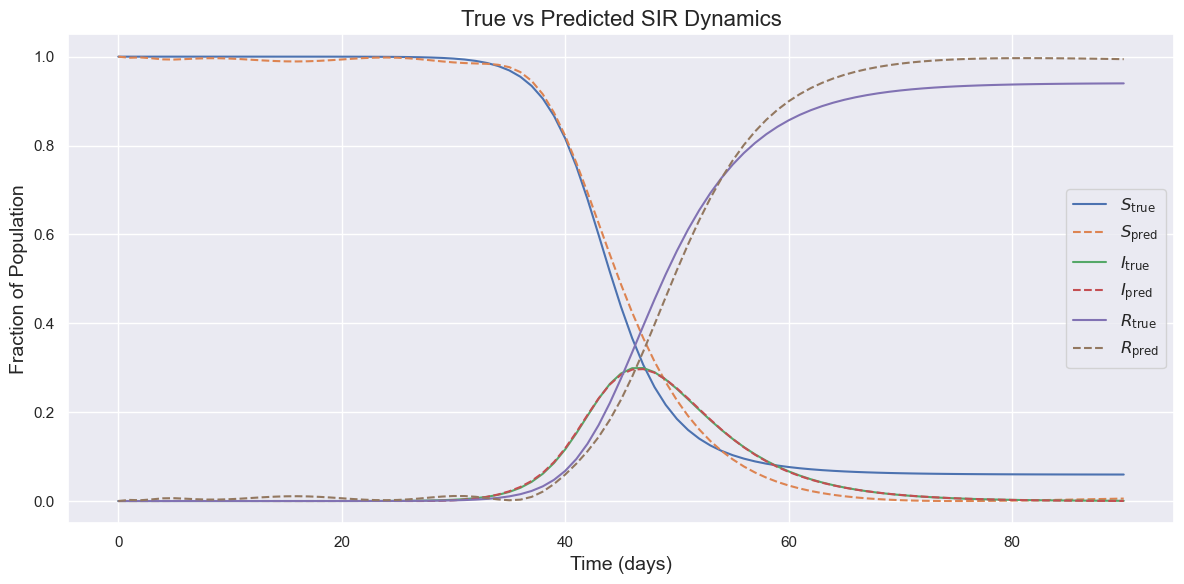

In [32]:
# save_training()
t_pred = t_tensor.cpu().detach().numpy().flatten()
s_pred, i_pred, r_pred = model(t_tensor).cpu().detach().numpy().T
beta_pred = model.beta.item()

plt.figure(figsize=(12, 6))

sns.lineplot(x=t_pred, y=s_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=s_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=i_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=i_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=r_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=r_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.title('True vs Predicted SIR Dynamics', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Fraction of Population', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f"{figures_dir}/sir_predictions.png", dpi=300)

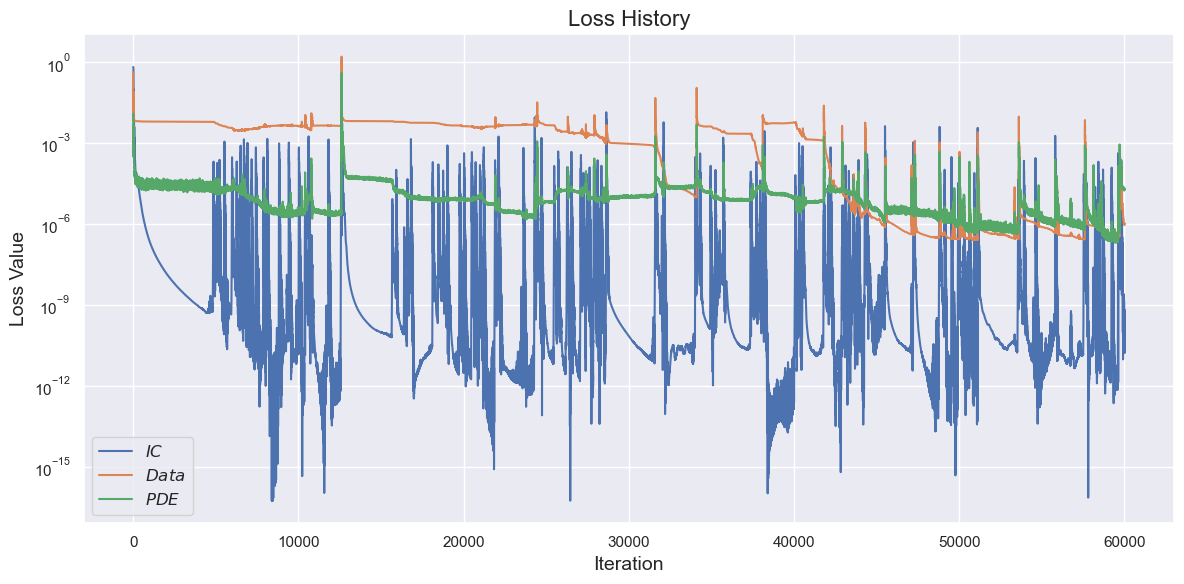

In [33]:
plt.figure(figsize=(12, 6))

# order matters for the overlaps
sns.lineplot(data=loss_df['L_ic'], label='$IC$')
sns.lineplot(data=loss_df['L_data'], label='$Data$')
sns.lineplot(data=loss_df['L_pde'], label='$PDE$')

plt.title('Loss History', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.yscale('log')

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/loss_history.png', dpi=300)

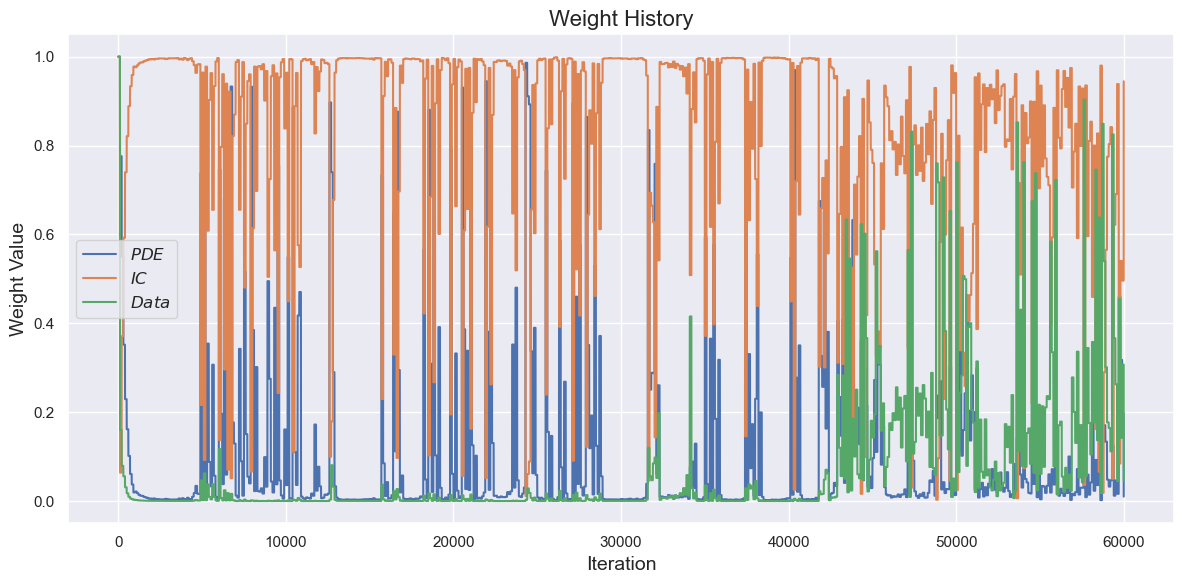

In [34]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['weight_pde'], label='$PDE$')
sns.lineplot(data=loss_df['weight_ic'], label='$IC$')
sns.lineplot(data=loss_df['weight_data'], label='$Data$')

plt.title('Weight History', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Weight Value', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/weight_history.png', dpi=300)

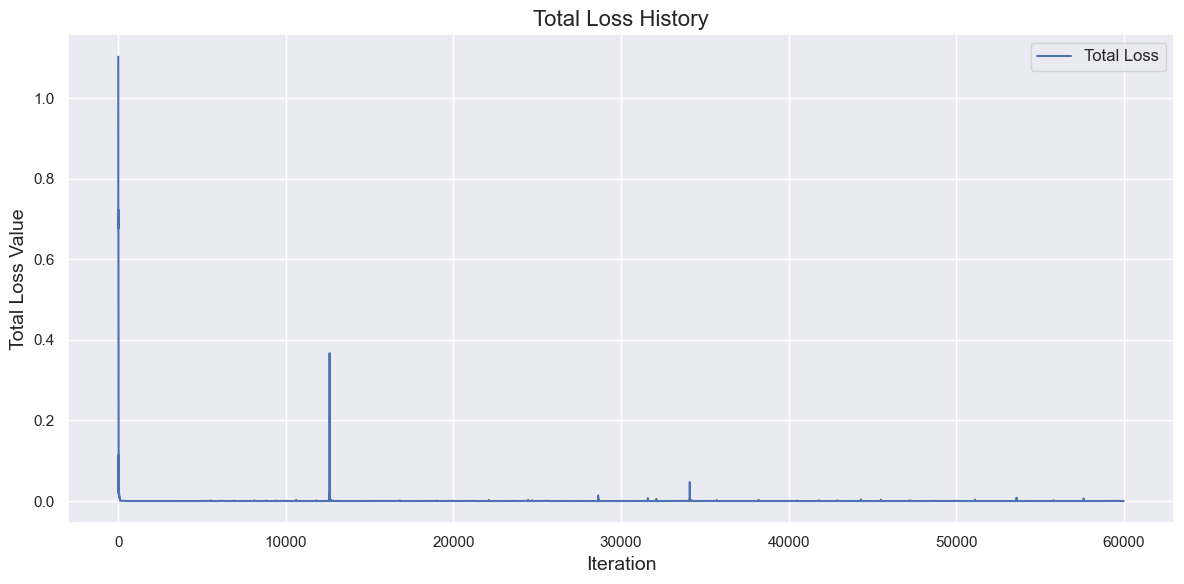

In [35]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['total_loss'], label='Total Loss')

plt.title('Total Loss History', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Total Loss Value', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/total_loss_history.png', dpi=300)

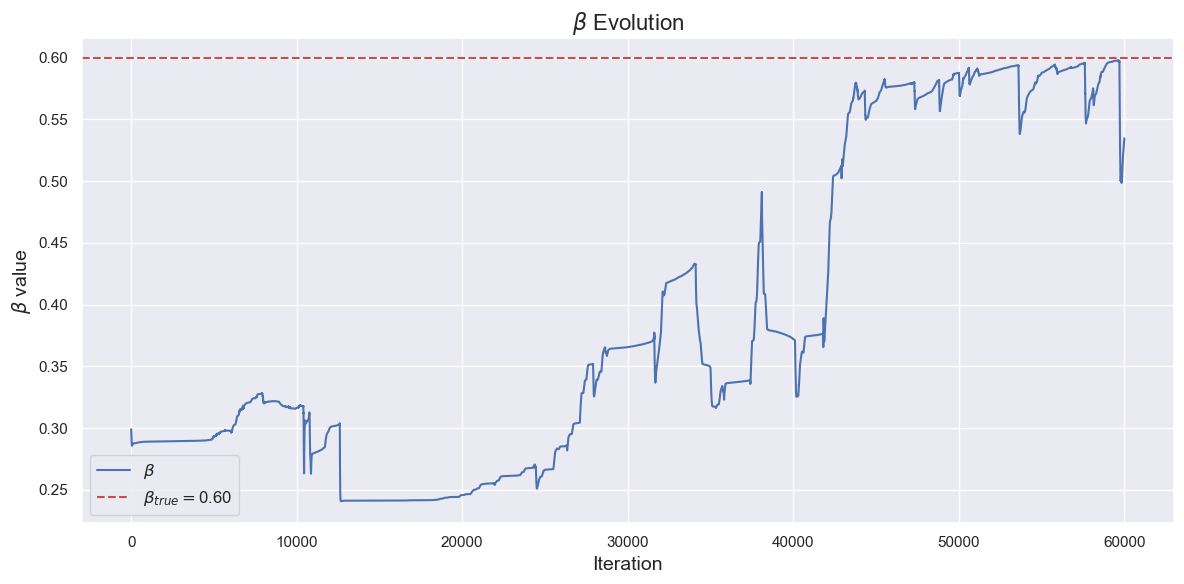

In [36]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=evolution_df['beta'], label='$\\beta$')
plt.axhline(
  y=beta_true,
  color='r',
  linestyle='--',
  label='$\\beta_{true} = $' + f'{beta_true:.2f}'
)

plt.title(f'$\\beta$ Evolution', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\beta$ value', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/beta_evolution.png', dpi=300)

In [37]:
def mse(pred, true):
  """Calculate Mean Squared Error between predicted and true values."""
  return np.mean((pred - true) ** 2)


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def mape(pred, true):
  """Calculate Mean Absolute Percentage Error between predicted and true values."""
  return mean_absolute_percentage_error(true, pred)


compartments = ["S", "I", "R"]
pred_arrays = [s_pred, i_pred, r_pred]
true_arrays = [s_true, i_true, r_true]

mse_values = [
  f"{mse(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
re_values = [
  f"{re(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
mape_values = [
  f"{mape(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]

errors = pd.DataFrame(
  {
    "Compartment": compartments,
    "MSE":         mse_values,
    "MAPE (%)":    mape_values,
    "RE":          re_values,
  }
)

display(HTML(errors.to_html(index=False)))

Compartment,MSE,MAPE (%),RE
S,1.40e-03,3.47e-01,5.48e-02
I,9.61e-07,5.57e+01,9.73e-03
R,1.40e-03,1.52e+09,6.25e-02


In [38]:
beta_error = abs(beta_pred - beta_true)
beta_error_percent = beta_error / beta_true * 100

beta_errors = pd.DataFrame(
  {
    "Parameter":          ["β"],
    "Predicted Value":    [f"{beta_pred:.4f}"],
    "True Value":         [f"{beta_true:.4f}"],
    "Absolute Error":     [f"{beta_error:.2e}"],
    "Relative Error (%)": [f"{beta_error_percent:.2f}%"],
  }
)

display(HTML(beta_errors.to_html(index=False)))

Parameter,Predicted Value,True Value,Absolute Error,Relative Error (%)
β,0.5346,0.6000,6.54e-02,10.90%
